# **Credit Card Fraud Detection using Scikit-Learn and Snap ML**


In [49]:
!pip install snapml

In [50]:
#install required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import gc, sys
from sklearn.metrics import accuracy_score

In [51]:
raw_data = pd.read_csv('creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")
raw_data.head()

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [52]:
#In practice, a financial institution may have access to a much larger dataset of transactions. To simulate such a case, we will inflate the original one 10 times.
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


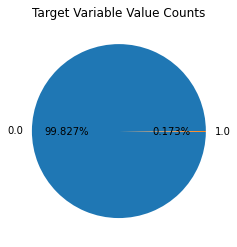

In [53]:
#Class is the target variable.
#get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values:

- 0 (the credit card transaction is legitimate)  
- 1 (the credit card transaction is fraudulent)

Thus,It requires binary classification model. Moreover, **the dataset is highly unbalanced**, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at training time is to _bias the model to pay more attention to the samples in the minority class_. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.


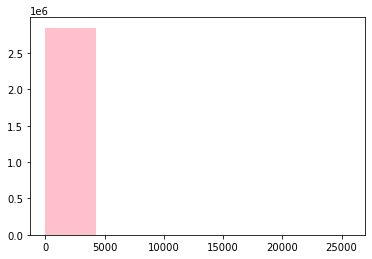

Minimum amount value is  0.0
Maximum amount value is  25691.16
90% of the transactions have an amount less or equal than  203.0


In [54]:
plt.hist(big_raw_data.Amount.values,6,histtype='bar',facecolor='pink')
plt.show()
print("Minimum amount value is ", np.min(big_raw_data.Amount.values))
print("Maximum amount value is ", np.max(big_raw_data.Amount.values))
print("90% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 90))

## Dataset Preprocessing


In [55]:
#Scaling/normalization is typically useful for linear models to accelerate the training convergence. 
#Standardize features by removing the mean and scaling to unit variance.
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


We are dealing with a large dataset, thus we need to make sure we do not run out of memory. We can release the memory occupied by `raw_data` and `big_raw_data` as we do not need them anymore.


In [56]:
#Delete features that are not required.
del raw_data
del big_raw_data
gc.collect()

5142

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


## Decision Trees


We compute the `sample_weights` to be used as input to the training routine so that it takes into account the class imbalance present in this dataset.


In [58]:
w_train = compute_sample_weight('balanced', y_train)

In [59]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

In [61]:
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  70.71629


In [62]:
from snapml import DecisionTreeClassifier

Snap ML offers multi-threaded CPU/GPU training of decision trees, unlike scikit-learn. To use the GPU, set the parameter `use_gpu = True`:

`snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, use_gpu=True)`


To set the number of CPU threads used at training time, set the `n_jobs` parameter. For reproducible output across multiple function calls, set `random_state` to a given integer value.


In [63]:
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)

In [64]:
# train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  6.53781


<div id="dt_sklearn_snapml">
    <h3>Evaluate the Scikit-Learn and Snap ML Decision Tree Classifiers</h3>
</div>


In [65]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 10.82x 


In [66]:
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

In [67]:
# ROC-AUC score of the predictions of both classifiers.
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

snapml_roc_auc = roc_auc_score(y_test, snapml_pred)   
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

[Scikit-Learn] ROC-AUC score : 0.966
[Snap ML] ROC-AUC score : 0.966


## Support Vector Machines


<div id="svm_sklearn">
    <h3>Support Vector Machine model with Scikit-Learn</h3>
</div>


In [68]:
from sklearn.svm import LinearSVC

In [69]:
#Instatiate a scikit-learn SVM model. To indicate the class imbalance at training time, set `class_weight='balanced'`.
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

In [70]:
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

C:\Users\SRI\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[Scikit-Learn] Training time (s):  93.25


C:\Users\SRI\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<div id="svm_snap">
    <h3>Support Vector Machine model with Snap ML</h3>
</div>


In [71]:
from snapml import SupportVectorMachine

In contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of SVMs. To use the GPU, set `use_gpu = True`. To set the number of threads used at training time, one needs to set the `n_jobs` parameter.


In [72]:
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
print(snapml_svm.get_params())

{'class_weight': 'balanced', 'device_ids': [], 'fit_intercept': False, 'gamma': 1.0, 'generate_training_history': None, 'intercept_scaling': 1.0, 'kernel': 'linear', 'loss': 'hinge', 'max_iter': 1000, 'n_components': 100, 'n_jobs': 4, 'normalize': False, 'random_state': 25, 'regularizer': 1.0, 'tol': 0.001, 'use_gpu': False, 'verbose': False}


In [73]:
t0 = time.time()
model = snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.2f}".format(snapml_time))

[Snap ML] Training time (s):  15.72


<div id="svm_sklearn_snap">
    <h3>Evaluate the Scikit-Learn and Snap ML Support Vector Machine Models</h3>
</div>


In [74]:
# the Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : 5.93x 


In [75]:
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred = snapml_svm.decision_function(X_test)

In [28]:
#ROC-AUC score of the predictions of both models.
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

acc_snapml  = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] ROC-AUC score:   {0:.3f}".format(acc_snapml))

[Scikit-Learn] ROC-AUC score:   0.984
[Snap ML] ROC-AUC score:   0.985


In [29]:
from sklearn.metrics import hinge_loss

# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred  = snapml_svm.decision_function(X_test)

# evaluate the hinge loss metric for Sklearn
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_sklearn))

# evaluate the hinge loss for Snap ML
loss_snapml = hinge_loss(y_test, snapml_pred)
print("[Snap ML] Hinge loss:   {0:.3f}".format(loss_snapml))

[Scikit-Learn] Hinge loss:   0.234
[Snap ML] Hinge loss:   0.228


**Logistic Regression**

In [41]:
from sklearn.linear_model import LogisticRegression
logistic_model= LogisticRegression()
logistic_model.fit(X_train,y_train)

LogisticRegression()

In [31]:
X_Train_prediction = logistic_model.predict(X_train)

In [32]:
Training_prediction_accuracy = accuracy_score(X_Train_prediction , y_train)

In [33]:
print('Accuracy on Training data : ',Training_prediction_accuracy )

Accuracy on Training data :  0.9993007796257014


In [34]:
X_test_prediction = logistic_model.predict(X_test)
Test_prediction_accuracy = accuracy_score(X_test_prediction , y_test)
print('Accuracy on Test data : ',Test_prediction_accuracy)

Accuracy on Test data :  0.9993141554339138


In [39]:
roc_auc = roc_auc_score(y_test, X_test_prediction)
print('ROC AUC score:', roc_auc)

ROC AUC score: 0.8545827626777754
